In [1]:
import pandas as pd
import numpy as np
import random
import tqdm

In [2]:
SIGMA_SL = -1
SIGMA_TP = 1.5
MAX_TRADE_DURATION = 63
PTF_VOL_TGT = 0.15
AUM = 100000
AUM_LOST_SL = 0.01

In [3]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

In [4]:
def optimal_number_trades(df,
                            incipit_date,
                            SIGMA_SL,
                            SIGMA_TP,
                            MAX_TRADE_DURATION, 
                            PTF_VOL_TGT,
                            AUM, 
                            AUM_LOST_SL):
    """
    function does....
    """

    if (incipit_date <= '2014-02-12') | (incipit_date >= '2023-02-12'):
        raise ValueError('incipit_date must be between 2014-02-12 and 2023-02-12')

    # refill Sat&Sun
    refilled = df.reindex(pd.date_range(df.index.min(), df.index.max()), method='ffill')

    # create list of dates for simulated trades
    date_index_reference = df.loc[pd.to_datetime(incipit_date):pd.to_datetime(incipit_date)+pd.DateOffset(years=1)].index
    startdates = list(date_index_reference.astype(str))

    # create df to store results of the trades
    trades_df = pd.DataFrame()
    ctrvl_aum = pd.DataFrame(index = date_index_reference)
    ctrvl_aum['AUM'] = AUM
    ctrvl_pos = pd.DataFrame(index = date_index_reference)

    # initialization of portfolio volatility
    portfolio_volatility = 0

    # generate random trades until portfolio volatility is below target
    while portfolio_volatility < PTF_VOL_TGT:
        security_id = random.choice(list(df.columns))
        trade_entry_date = random.choice(startdates)
        direction = random.choice([-1, 1])

        # compute 5Y Monthly standard deviation starting from date of trade entry and going backward to compute trade's TP/SL
        hist_stdev = refilled.loc[
            refilled.index.isin(pd.date_range(end=trade_entry_date, periods=60+1, freq=pd.DateOffset(months=1))), security_id
                ].pct_change().dropna().std()
        
        # create trade's PnL df
        trade_pnl = df.loc[trade_entry_date:, [security_id]].head(MAX_TRADE_DURATION+1)
        trade_pnl['security_id'] = security_id
        trade_pnl['direction'] = direction
        trade_pnl['hist_volatility'] = hist_stdev
        trade_pnl['entry_price'] = df.loc[trade_entry_date, security_id]
        trade_pnl['tp_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * SIGMA_TP * direction)
        trade_pnl['sl_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * SIGMA_SL * direction)
        trade_pnl['quantity'] = (AUM * AUM_LOST_SL) / ((trade_pnl['entry_price'] - trade_pnl['sl_price']) * direction)

        # check if TP/SL have been hitted 
        if direction == 1:
            trade_pnl['tp_hit'] = (trade_pnl[security_id] > trade_pnl['tp_price']) * 1
            trade_pnl['sl_hit'] = (trade_pnl[security_id] < trade_pnl['sl_price']) * 1
        elif direction == -1:
            trade_pnl['tp_hit'] = (trade_pnl[security_id] < trade_pnl['tp_price']) * 1
            trade_pnl['sl_hit'] = (trade_pnl[security_id] > trade_pnl['sl_price']) * 1

        trade_pnl['tp_sl_hit'] = trade_pnl['tp_hit'] + trade_pnl['sl_hit']

        # make exit condition from the trade explicit
        if trade_pnl['tp_sl_hit'].sum()==0:
            trade_pnl['exit_condition'] = 'max_duration'
            trade_pnl['exit_price'] = trade_pnl[security_id].iloc[-1]
        else:
            trade_pnl = trade_pnl.loc[:trade_pnl[trade_pnl['tp_sl_hit'] == 1].index[0]].copy()
            trade_pnl['exit_condition'] = 'stop_loss' if trade_pnl['sl_hit'].sum()==1 else 'take_profit'
            trade_pnl['exit_price'] = trade_pnl['sl_price'] if trade_pnl['sl_hit'].sum()==1 else trade_pnl['tp_price']

        # first day must be subtracted as it is the day when the trade is open
        trade_pnl['duration'] = len(trade_pnl)-1

        # store the trade
        trades_df = pd.concat([trades_df, trade_pnl[['security_id', 'direction', 'hist_volatility', 'entry_price',
            'tp_price', 'sl_price', 'quantity', 'exit_condition', 'exit_price', 'duration']].drop_duplicates()]).sort_index()
        
        # store controvalore
        ctrvl_aum = pd.concat([ctrvl_aum, 
                        (trade_pnl['entry_price'] * trade_pnl['quantity']).rename(f'{security_id}#{trade_entry_date}')], axis=1)
        
        ctrvl_pos = pd.concat([ctrvl_pos, 
                        (trade_pnl[security_id] * trade_pnl['quantity']).rename(f'{security_id}#{trade_entry_date}')], axis=1)
        
        ctrvl_aum = ctrvl_aum.ffill().fillna(0)
        aum_net = ctrvl_aum['AUM'] - ctrvl_aum.iloc[:, 1:].sum(axis=1)

        portfolio_volatility = (ctrvl_pos.ffill().fillna(0).sum(axis=1) + aum_net).pct_change().std() * np.sqrt(252)

    number_of_trades = len(trades_df)
    
    return portfolio_volatility, aum_net, ctrvl_pos, trades_df, number_of_trades

In [13]:
# refill Sat&Sun
refilled = df.reindex(pd.date_range(df.index.min(), df.index.max()), method='ffill')

incipit_date = '2018-03-12'

date_index_reference = df.loc[pd.to_datetime(incipit_date):pd.to_datetime(incipit_date)+pd.DateOffset(years=1)].index
startdates = list(date_index_reference.astype(str))


trades_df = pd.DataFrame()
ctrvl_aum = pd.DataFrame(index = date_index_reference)
ctrvl_aum['AUM'] = AUM
ctrvl_pos = pd.DataFrame(index = date_index_reference)

portfolio_volatility = 0

while portfolio_volatility < PTF_VOL_TGT:
    security_id = random.choice(list(df.columns))
    trade_entry_date = random.choice(startdates)
    direction = random.choice([-1, 1])

    # compute 5Y Monthly standard deviation starting from date of trade entry and going backward
    hist_stdev = refilled.loc[refilled.index.isin(pd.date_range(end=trade_entry_date, periods=60+1, freq=pd.DateOffset(months=1))), security_id
                    ].pct_change().dropna().std() #* np.sqrt(12)

    trade_pnl = df.loc[trade_entry_date:, [security_id]].head(MAX_TRADE_DURATION+1)
    trade_pnl['security_id'] = security_id
    trade_pnl['direction'] = direction
    trade_pnl['hist_volatility'] = hist_stdev
    trade_pnl['entry_price'] = df.loc[trade_entry_date, security_id]
    trade_pnl['tp_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * SIGMA_TP * direction)
    trade_pnl['sl_price'] = trade_pnl['entry_price'] * (1 + hist_stdev * SIGMA_SL * direction)
    trade_pnl['quantity'] = (AUM * AUM_LOST_SL) / ((trade_pnl['entry_price'] - trade_pnl['sl_price']) * direction)

    # check if TP/SL have been hitted 
    if direction == 1:
        trade_pnl['tp_hit'] = (trade_pnl[security_id] > trade_pnl['tp_price']) * 1
        trade_pnl['sl_hit'] = (trade_pnl[security_id] < trade_pnl['sl_price']) * 1
    elif direction == -1:
        trade_pnl['tp_hit'] = (trade_pnl[security_id] < trade_pnl['tp_price']) * 1
        trade_pnl['sl_hit'] = (trade_pnl[security_id] > trade_pnl['sl_price']) * 1

    trade_pnl['tp_sl_hit'] = trade_pnl['tp_hit'] + trade_pnl['sl_hit']

    # make exit condition from the trade explicit
    if trade_pnl['tp_sl_hit'].sum()==0:
        trade_pnl['exit_condition'] = 'max_duration'
        trade_pnl['exit_price'] = trade_pnl[security_id].iloc[-1]
    else:
        trade_pnl = trade_pnl.loc[:trade_pnl[trade_pnl['tp_sl_hit'] == 1].index[0]].copy()
        trade_pnl['exit_condition'] = 'stop_loss' if trade_pnl['sl_hit'].sum()==1 else 'take_profit'
        trade_pnl['exit_price'] = trade_pnl['sl_price'] if trade_pnl['sl_hit'].sum()==1 else trade_pnl['tp_price']

    # first day must be subtracted as it is the day when the trade is open
    trade_pnl['duration'] = len(trade_pnl)-1

    # store the trade
    trades_df = pd.concat([trades_df, trade_pnl[['security_id', 'direction', 'hist_volatility', 'entry_price',
       'tp_price', 'sl_price', 'quantity', 'exit_condition', 'exit_price', 'duration']].drop_duplicates()]).sort_index()
    
    # store controvalore
    ctrvl_aum = pd.concat([ctrvl_aum, 
                    (trade_pnl['entry_price'] * trade_pnl['quantity']).rename(f'{security_id}#{trade_entry_date}')], axis=1)
    
    ctrvl_pos = pd.concat([ctrvl_pos, 
                    (trade_pnl[security_id] * trade_pnl['quantity']).rename(f'{security_id}#{trade_entry_date}')], axis=1)
    
    ctrvl_aum = ctrvl_aum.ffill().fillna(0)
    aum_net = ctrvl_aum['AUM'] - ctrvl_aum.iloc[:, 1:].sum(axis=1)

    portfolio_volatility = (ctrvl_pos.ffill().fillna(0).sum(axis=1) + aum_net).pct_change().std() * np.sqrt(252)


print('number of trades:', len(trades_df))

number of trades: 77


0.15113543717991276 137


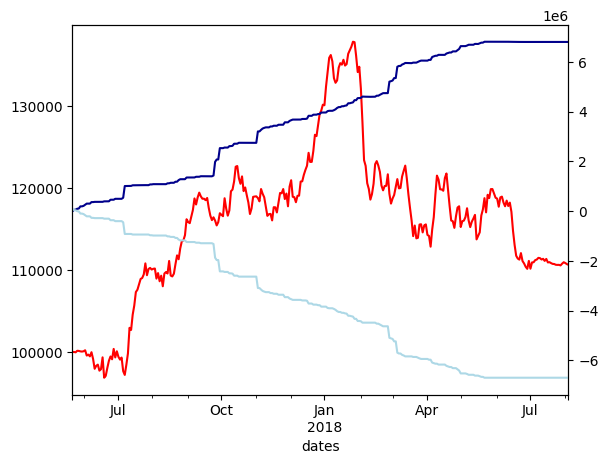

In [5]:
portfolio_volatility, aum_net, ctrvl_pos, trades_df, number_of_trades = optimal_number_trades(df,
                            '2017-05-23',
                            SIGMA_SL,
                            SIGMA_TP,
                            MAX_TRADE_DURATION, 
                            PTF_VOL_TGT,
                            AUM, 
                            AUM_LOST_SL)

(ctrvl_pos.ffill().fillna(0).sum(axis=1) + aum_net).plot(color='red')
(ctrvl_pos.ffill().fillna(0).sum(axis=1)).plot(color='darkblue', secondary_y=True)
(aum_net).plot(color='lightblue', secondary_y=True)
print(portfolio_volatility, len(trades_df))

In [27]:
prob_res = {}
for i in tqdm.tqdm(range(100)):
    portfolio_volatility, aum_net, ctrvl_pos, trades_df, number_of_trades = optimal_number_trades(df,
                            '2017-05-23',
                            SIGMA_SL,
                            SIGMA_TP,
                            MAX_TRADE_DURATION, 
                            PTF_VOL_TGT,
                            AUM, 
                            AUM_LOST_SL)
    
    prob_res[portfolio_volatility] = number_of_trades

prob_res = pd.DataFrame(prob_res, index=['number_of_trades']).T.reset_index().rename({'index':'ptf_volat'}, axis=1)
print(f"optimal number of trades: {round(prob_res['number_of_trades'].mean())} +/- {round(prob_res['number_of_trades'].std())}")

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]

optimal number of trades: 105 +/- 15
